In [1]:
dataset= 'Synthetic-2d'  #Name of the dataset from ['Adult','Bank']
order= 'random'  # Order of data points with respect to protected group - random or arbitrary

Ktarget = 20   #Target or desired number of clusters 


#Point 1. Capture all costs as squared euclidean 

In [2]:
import numpy as np
import math
import pandas as pd
from sklearn.utils import shuffle
import random
import numba
from numba import jit , njit
from csv import writer
import time
from scipy.spatial import distance
#!pip install scikit-learn-extra
from sklearn.cluster import KMeans
import itertools
import matplotlib.pyplot as plt

In [3]:
def load_dataset(dataset,Ktarget):
    
    flag= True
    if dataset=='Adult':
        _filename = 'adult_p.csv'
        OriCenters=[]
    elif dataset=='Bank':
        _filename = 'bank_p.csv'
        OriCenters=[]
        
    elif dataset=='Synthetic-1d':
        
        OriCenters=[1]
        cluster1 = np.random.normal([1], 2, 1000)
        
            
        df=pd.DataFrame(cluster1, columns=['X'])
        for kk in range(1,Ktarget):
           
            cluster1 = np.random.normal([1+7*kk],2 , 1000)
            OriCenters.append([1+7*kk])
           
          
            df1=pd.DataFrame(cluster1, columns=['X'])
            df=pd.concat([df,df1])
            
      
        df = df.reset_index()  
        
        df = df.drop(df.columns[0],axis=1)
       
        df=shuffleDataset(df)
        OriCenters=np.array(OriCenters)
        flag= False
        
        
    elif dataset=='Synthetic-2d-over':
        

        cluster1 = np.random.multivariate_normal([1,3], [[1, 0], [0, 1]], 1000)
        OriCenters=[[1,3]]
            
        df=pd.DataFrame(cluster1, columns=['X','Y'])
        for kk in range(1,Ktarget):
           
            cluster1 = np.random.multivariate_normal([1+5*kk,3], [[1, 0], [0, 1]], 1000)
            
            OriCenters.append([1+5*kk,3])
          
            df1=pd.DataFrame(cluster1, columns=['X','Y'])
            df=pd.concat([df,df1])
            
      
        df = df.reset_index()
        df = df.drop(df.columns[0],axis=1)
        #print(df)
        
        
        plot2Ddata(df['X'],df['Y'])
        df=shuffleDataset(df)
        OriCenters=np.array(OriCenters)
        flag= False
    
        
        
        
    elif dataset=='Synthetic-2d': #well separated
        

        cluster1 = np.random.multivariate_normal([1,3], [[1, 0], [0, 1]], 1000)
        OriCenters=[[1,3]]
            
        df=pd.DataFrame(cluster1, columns=['X','Y'])
        for kk in range(1,Ktarget):
           
            cluster1 = np.random.multivariate_normal([1+7*kk,3], [[1, 0], [0, 1]], 1000)
            
            OriCenters.append([1+7*kk,3])
          
            df1=pd.DataFrame(cluster1, columns=['X','Y'])
            df=pd.concat([df,df1])
            
      
        df = df.reset_index()
        df = df.drop(df.columns[0],axis=1)
        #print(df)
        
        
        plot2Ddata(df['X'],df['Y'])
        df=shuffleDataset(df)
        OriCenters=np.array(OriCenters)
        flag= False
        
    elif dataset=='Synthetic-1d-Over':
        
        OriCenters=[1]
        cluster1 = np.random.normal([1], 2, 1000)
        
            
        df=pd.DataFrame(cluster1, columns=['X'])
        for kk in range(1,Ktarget):
           
            cluster1 = np.random.normal([1+5*kk],2 , 1000)
            OriCenters.append([1+5*kk])
           
          
            df1=pd.DataFrame(cluster1, columns=['X'])
            df=pd.concat([df,df1])
            
      
        df = df.reset_index()  
        
        df = df.drop(df.columns[0],axis=1)
       
        df=shuffleDataset(df)
        OriCenters=np.array(OriCenters)
        flag= False
        
    elif dataset=='Synthetic-arb':
        flag= False
        pass
    
    if flag:
        
        df = pd.read_csv(_filename, sep=',')#[:10000]
        df= df.round(decimals=5)
        df = df.dropna()
    
        if order=='random':
            df=shuffleDataset(df)
        
    print('Dataset loaded........')
    
    #df.to_csv('SeededData/'+str(dataset)+'_seed_'+str(seed)+'.csv',index=False)
    
    return df,OriCenters
        
def plot2Ddata(x,y):
    plt.plot(x, y, 'x')
    plt.axis('equal')
    plt.show()

In [4]:
def shuffleDataset(df):

    df = shuffle(df)
    df = shuffle(df)    #random with respect to group and distance
    df = shuffle(df)
    df = df.reset_index()
    df = df.drop(columns='index')
    return df
    
    

In [5]:
@njit(parallel=False)
def EuclideanDistance(x,y):
    sum_ = 0
    
    for i in range(0,len(x)):
        
        sum_ = sum_ + (x[i]-y[i])**2

    return sum_#**0.5


def EuclideanDistance_(x,y):
    sum_ = 0
#     print(x)
#     print(y)
#     print()
    
    for i in range(0,len(x)):
        
        sum_ = sum_ + (x[i]-y[i])**2

    return sum_#**0.5


In [6]:
@njit(parallel=False)
def Distances(rows,center): 
    # Numpy array - center and rows
    #Finds the distance of rows to 1 center in fast parallel way
    
    #need centers in col
    rr = len(rows)
    cc = len(center) 
   
    dist=np.zeros((rr, cc)) 
    
    
    
    for indr in range(0,len(rows)):
        
        
        
        for indce in range(0,len(center)):
            
            dis = EuclideanDistance(rows[indr],center[indce])
            dist[indr][indce]= dis
            
    
    return dist
 
#@njit(parallel=False)
def sortedDistances1(centers,row): 
    # Numpy array - center and rows
    #Finds the distance of rows to 1 center in fast parallel way
    
    distOfCenters = []
    
    
    for indce in range(0,len(centers)): # each center is tuple of index, center vector 
        dis = EuclideanDistance_(row,centers[indce][1])
        distOfCenters.append(tuple((dis,centers[indce][0])))  #add distance, original center id 
        
            
    #sorted_centers = sorted(distToCenters, key=lambda x: x[0])
    distOfCenters.sort()  #inPlace sorts 
    
    
    return distOfCenters
            
   

In [7]:
def CapHeur(Ktarget,X,capacities):
    
    n_row, n_col = X.shape
    rand_indices = np.random.choice(n_row, size = Ktarget)
    maxiter=100
  
    centroids = X[rand_indices]

    
   
    for itr in range(maxiter):
        distances_to_centroids = Distances(X, centroids)#distance.cdist(X, centroids, 'sqeuclidean')
        

        
        cluster_assignment=[]
        
        capacities_iter= np.array(capacities,dtype=np.int64)#(tuple of form (center idx,capacity))
        #Deep copies it into this np.array()
        
        for idx in range(0,len(X)):
            #print(distances_to_centroids[idx])
            sorted_centerIDs = np.argsort(distances_to_centroids[idx])
            
            for idc in sorted_centerIDs:
            
                if capacities_iter[int(idc)][1] >0:
                    cluster_assignment.append(idc)
                    capacities_iter[int(idc)][1] -=1
                    break
                    
                    
        #print("Found {} assignements for iteration {}.".format(len(cluster_assignment), itr))
               
        cluster_assignment=np.array(cluster_assignment)   
        
        new_centroids=[]
        for i  in range(Ktarget):
            
            assign= np.array([X[cluster_assignment == i]])
            #print('shape of assign is ',assign)
            med = np.mean(assign,axis=1)
            #print('shape of med is ',med)
            new_centroids.append(med)
            
            
       
            
        new_centroids = np.array(new_centroids)
        new_centroids = new_centroids.reshape(Ktarget,len(X[0]))
        
            
        if np.all(centroids == new_centroids):
                break
        
        centroids = new_centroids
        #print('centroids are ',centroids)
            
    
    
    cost = []
    for i in range(Ktarget):
        cluster_data = X[cluster_assignment == i]
        distances = distance.cdist(cluster_data, [centroids[i]], 'euclidean')
        cost.append( np.sum(distances ** 2))
    
    return np.sum(cost)


def LowerBoundCapHeuristic(Ktarget,dfValues):
    
    w_list = []
    seeds=[0,100,200,300,400,500,600,700,800,900]
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        
        capacities=[]
        
        for i in range(Ktarget):
            capacities.append([i,np.ceil(len(dfValues)/Ktarget)])  #(centerId,capacity)
        
        w_list.append(CapHeur(Ktarget,dfValues,capacities))
        
        
    return w_list

In [8]:
def Algo():
    return []

def LowerBoundCapSOTA(Ktarget):
    
    seeds=[0,100,200,300,400,500,600,700,800,900]
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        
        w_list = Algo()
        
    return w_list

In [9]:
#Utility functions

def CostVanillaKmeanspp(Ktarget,dfValues):
    #k-means++

    seeds=[0,100,200,300,400,500,600,700,800,900]
    cost = []
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        kmean_obj = KMeans(n_clusters=Ktarget, init='k-means++' ,random_state=seed).fit(dfValues)
        
        cost.append(kmean_obj.inertia_)    #Sum of squarred euc dis 
        
    return np.mean(cost), np.std(cost)     #average over 10 runs  
 
    
def CostVanillaKmeansList(Ktarget,dfValues):
    
    
    seeds=[0,100,200,300,400,500,600,700,800,900]
    cost = []
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        kmean_obj = KMeans(n_clusters=Ktarget, init='random' ,random_state=seed).fit(dfValues)
        
        cost.append(kmean_obj.inertia_)    #Sum of squarred euc dis 
        
        labels = kmean_obj.labels_ 
        
        cluster_centers = kmean_obj.cluster_centers_
        
        cost_seed = []
        for i in range(Ktarget):
            cluster_data = dfValues[labels == i]
            distances = distance.cdist(cluster_data, [cluster_centers[i]], 'euclidean')
            cost_seed.append( np.sum(distances ** 2))
        cost.append(np.max(cost_seed))
        
        
    
        
    
    
    return cost#, np.std(cost)    #average over 10 runs     

def CostVanillaKmeans(Ktarget,dfValues):
    
    
    seeds=[0,100,200,300,400,500,600,700,800,900]
    cost = []
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        kmean_obj = KMeans(n_clusters=Ktarget, init='random' ,random_state=seed).fit(dfValues)
        
        cost.append(kmean_obj.inertia_)    #Sum of squarred euc dis 
        
    
    
    return np.mean(cost)#, np.std(cost)    #average over 10 runs     


def CostVanillaKrandom(Ktarget,dfValues):
    
    seeds=[0,100,200,300,400,500,600,700,800,900]
    cost = []
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        
        n_row, n_col = dfValues.shape
        rand_indices = np.random.choice(n_row, size = Ktarget)
        centroids = dfValues[rand_indices]
        
        distances_to_centroids = distance.cdist(dfValues, centroids, 'sqeuclidean')
        cluster_assignment = np.argmin(distances_to_centroids, axis = 1)
        heterogeneity=0
        for i in range(Ktarget):
            cluster_data = dfValues[cluster_assignment == i]
            distances = distance.cdist(cluster_data, [centroids[i]], 'euclidean')
            heterogeneity += np.sum(distances ** 2)
        
        cost.append(heterogeneity)
    
    return np.mean(cost)#, np.std(cost)

In [10]:
def ClusteringCost(Centers,Assignments,dfValues):
    #Centers is of form -> (indx,dfValues[indx])  , Assignment is 1d bearing centerID  dfValues are indexed rows.
    
    center_map = {}
    
    for idx, c in Centers:
        center_map[idx]=c
        
    
    cost = 0
    idx = 0 
    
    for each in Assignments:
        if each !=-1:
            cost += EuclideanDistance(dfValues[idx], center_map[each])
        
        idx += 1
        
    return cost #sq Cost 
        
        
        
    
    

In [11]:
def wStarHelper(Centers):
    #Centers are of form (indx,dfValues[indx])
    
    distances = []
    for idxi in range(0,len(Centers)):
        for idx in range(0, len(Centers)):
            if idx!=idxi:
                dis = EuclideanDistance_(Centers[idxi][1],Centers[idx][1])
                distances.append(dis)
    
    return np.min(np.array(distances))
        
        
        
    
    
    
    

In [12]:
def nCr(n, r):
    # If r is greater than n, return 0
    if r > n:
        return 0
     
    # If r is 0 or equal to n, return 1
    if r == 0 or n == r:
        return 1
    # Initialize the logarithmic sum to 0
    res = 0
     
    # Calculate the logarithmic sum of the numerator and denominator using loop
    for i in range(r):
        # Add the logarithm of (n-i) and subtract the logarithm of (i+1)
        res += math.log(n-i) - math.log(i+1)
    # Convert logarithmic sum back to a normal number
    return round(math.exp(res))

def CouponCollectorNonUniform(capacities,Ktarget):
    
    prob = []
    sum_ = 0 
    for each in capacities:
        sum_ += each[1]
        prob.append(each[1])
    prob=np.array(prob)
    
    prob=np.round(prob/sum_,2)
  
    expec =0
    lst = [i for i in range(0,Ktarget)]
    
    for m in range(1,Ktarget+1 ):
        
        multiplier= (-1)**(m-1)
     
        
        
        #pair_order_list = itertools.combinations(lst,m)  #Contains all possible tuples of size m 
        
        #pair_order_list = [i for i in range(0,nCr(Ktarget,m))]#list(itertools.combinations(lst,m))
    
        sum_inner=(1.0*nCr(Ktarget,m))/(prob[0]*m)
      

        
        #tuple of indexes (i,j,k)
        
        
        
        a = multiplier * sum_inner
        
        expec += (a)
    
    return int(np.ceil(np.round(expec,2)))
        
    
    
        
        
    
    
    

In [13]:

params = {'legend.fontsize': '15',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'22',
          'font.weight': '500',
           'axes.linewidth':2,
          'figure.titlesize':'xx-large',
         'ytick.labelsize':'20'}

plt.rcParams.update(params)
def plotClusters(dataset,dfValues,Centers,OriCenters,runNo,algo):
    
    centers =[]
    for idx, c in Centers:
        centers.append(c)
    centers= np.array(centers)
    
    plt.plot(dfValues[:,0], dfValues[:,1],'y.',label='Datapoints')
    plt.plot(centers[:,0], centers[:,1],'r+',label='Online centers')
    
    
        
    plt.plot(OriCenters[:,0], OriCenters[:,1],'k^',markersize=5, label='Original centers')
    
    plt.axis('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(dataset+': Run '+str(runNo))
    plt.legend(ncol=3)
    plt.savefig(algo+': '+dataset+'_'+str(len(Centers))+'_'+str(runNo)+'.png',dpi=600)
    plt.show()
    
#ax1.legend(bbox_to_anchor=(-0.01,1.2),loc='upper left',ncol=3,fancybox=True, shadow=False)

K target is  2


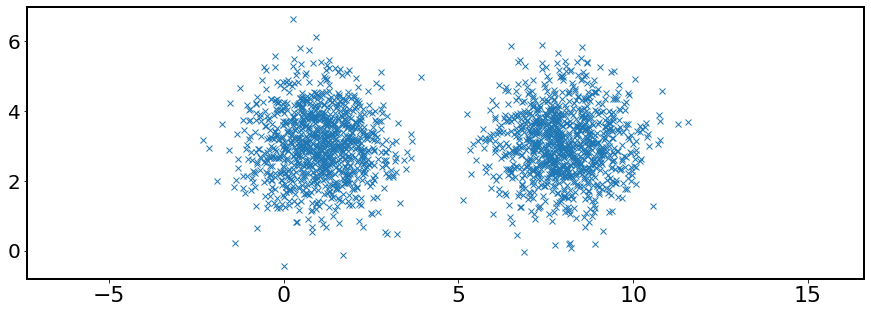

Dataset loaded........
M is  3


/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when cre

K target is  3


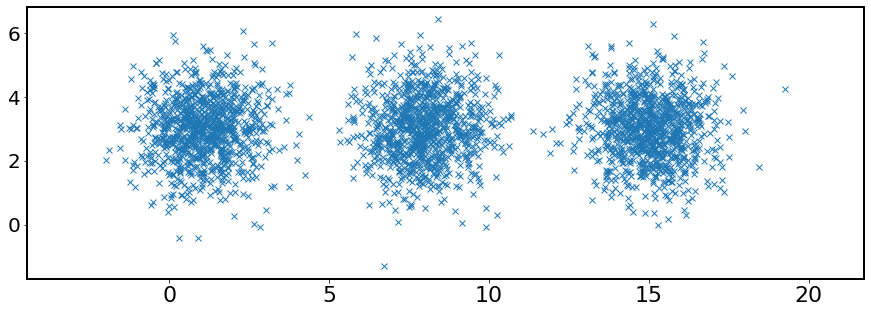

Dataset loaded........
M is  4


/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


K target is  5


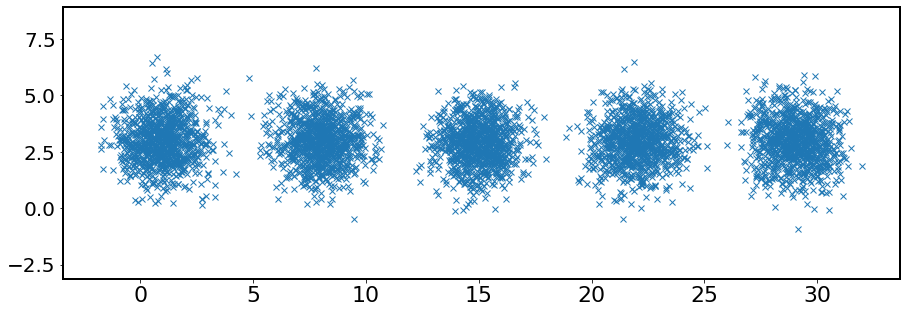

Dataset loaded........
M is  6


/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

K target is  7


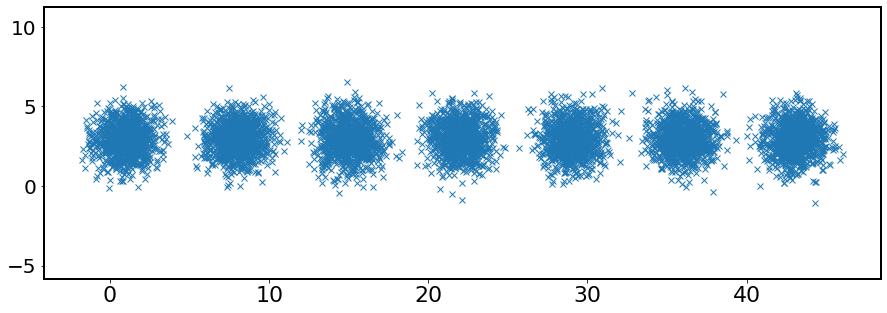

Dataset loaded........
M is  8


/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

K target is  10


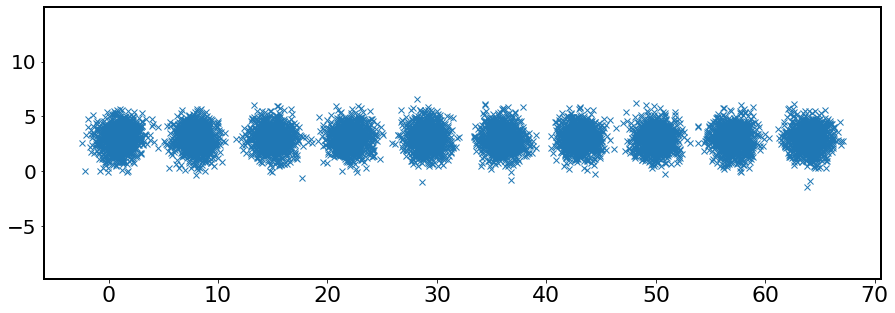

Dataset loaded........


/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


M is  11


/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


K target is  15


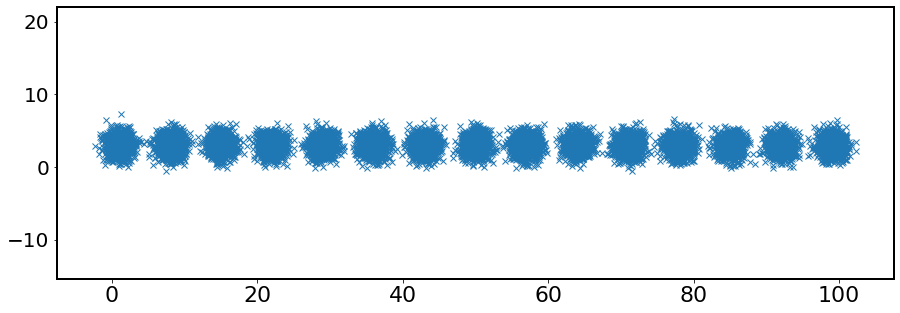

Dataset loaded........


/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


M is  16


/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


K target is  20


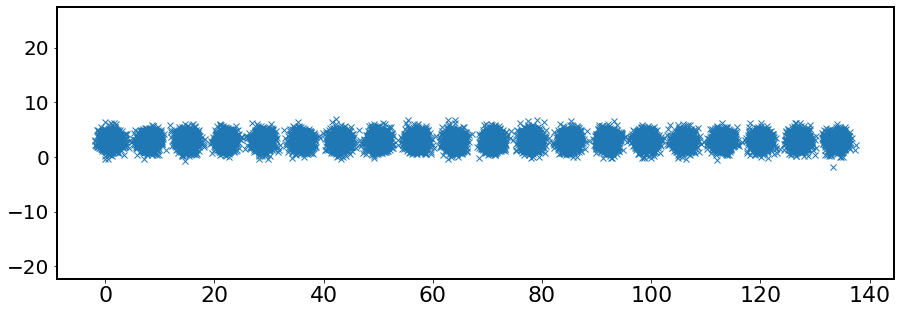

Dataset loaded........


/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


M is  21


/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


K target is  25


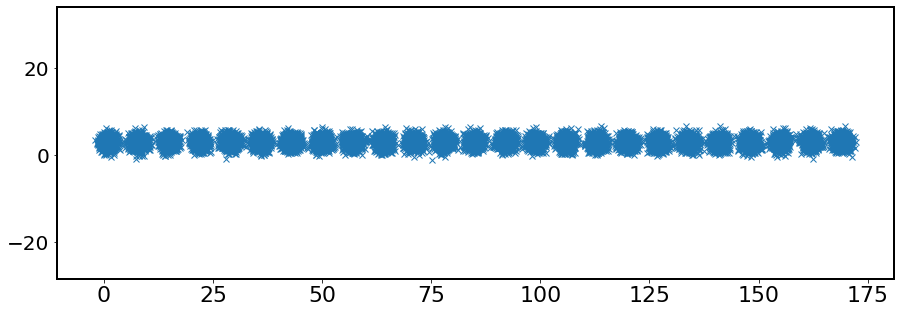

Dataset loaded........


/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


M is  26


/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


K target is  30


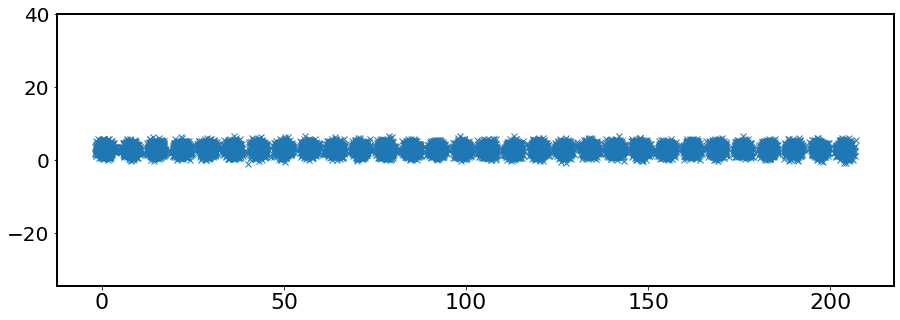

Dataset loaded........


/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


M is  31


/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


K target is  40


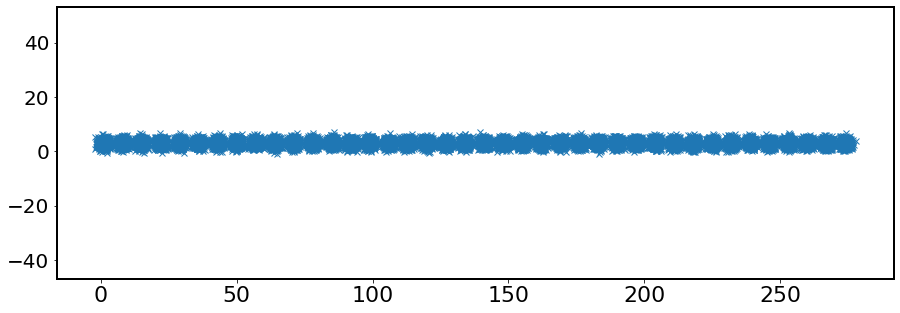

Dataset loaded........


/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lxc128/miniconda3/envs/FairClustering/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


M is  41


/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lxc128/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Opencenters_over_K_mean list  [6.3, 10.1, 16.0, 23.4, 32.5, 57.4, 62.6, 88.9, 94.2, 138.9]
Opencenters_over_K_std list  [0.6403124237432849, 0.3, 1.4832396974191326, 3.4985711369071804, 3.905124837953327, 5.0039984012787215, 6.2960304954788775, 7.595393340703298, 3.8935844667863564, 18.069034285207387]
Cost_over_K_mean list  [3630.1768, 4762.7792, 8974.0399, 11982.973799999998, 16597.7333, 20884.143900000003, 33974.6275, 37292.5465, 48969.9122, 63264.9017]
Cost_over_K_std list  [589.8663292107458, 508.2675434256648, 1273.6862413711196, 2958.8862495218973, 2791.6593568704275, 2773.322013621225, 5297.3671356338, 2415.8949433949415, 3923.6917550708495, 9042.967479012783]


True

In [14]:
KtargetList=[2,3,5,7,10,15,20,25,30,40]
Opencenters_over_K_mean = []
Opencenters_over_K_std=[]
Cost_over_K_mean = []
Cost_over_K_std=[]

def COCA():
    for Ktarget in KtargetList:
        print('K target is ',Ktarget)
        seeds=[0,100,200,300,400,500,600,700,800,900]
        no_of_centers = []
        clus_cost_list=[]
        f_r_over_run = []
        df,OriCenters = load_dataset(dataset,Ktarget)
        dfValues = df.values


        #LowerBound on capacitated clustering over different seedValues 
        #w_list_sota = LowerBoundCapSOTA(Ktarget)
        


        capacities_optimal=[]


        for i in range(Ktarget):
            capacities_optimal.append((i,np.ceil(len(dfValues))))  #(centerId,capacity)


        M =  Ktarget + 1 #min(CouponCollectorNonUniform(capacities_optimal,Ktarget),len(dfValues))
        N = len(dfValues)
        
        
        dfValuesM = dfValues[:M+1]
        w_list_heurM = LowerBoundCapHeuristic(Ktarget,dfValuesM)
        #w_list_VanillaM = CostVanillaKmeansList(Ktarget,dfValuesM)
        #print(w_list_heurM)
        #print(w_list_VanillaM)

        print('M is ',M)
        runNo = 0 
        for seed in seeds:
            random.seed(seed)
            np.random.seed(seed)
            
            interval_update = []
            f_r_over_time = []

            if order=='random':
                df=shuffleDataset(df)
                dfValues = df.values


            
            centersOpened_temp = 0 # Reset to 0 after every 3k(1+log n ) centers.

            Assignments = [] #Store in serial order index of center and store -1 if opened as center 
            CentersOpened = 0 
            Centers = []
            Capacities = []

            for indx in range(0,M):
                Centers.append((indx,dfValues[indx]))
                Capacities.append(np.ceil(len(dfValues)  ))
                Assignments.append(-1)
                CentersOpened+=1
                centersOpened_temp+=1

            Centers=np.array(Centers)

            CenterCost =w_list_heurM[runNo]/Ktarget # Center (or facility) opening cost i.e, w*/k1
            #print('Center opening cost is ',CenterCost)


            #print('if > ',np.ceil(3*Ktarget*(1+np.log(indx)) ))
            #print(centersOpened_temp)
            #start for rest of points after first M points ie 0 to M-1 index
            for indx in range(M,len(dfValues)):

                #print('centers round ',centersOpened_temp)
                if centersOpened_temp >= Ktarget:#np.ceil(3*Ktarget*Ktarget*(1+np.log(indx)) ):  #Reset after every 3k(1+logn) centers and double the cost for next rounds
                    CenterCost = CenterCost* 10 #It takes log(n) as log(current n read)10
                    centersOpened_temp=0
                    #print('*'*15)
                    interval_update.append(indx)


                f_r_over_time.append(np.round(CenterCost,2))
                
                x=dfValues[indx]

                #Step 1 : Find the closest center 
                distOfCenters=sortedDistances1(Centers,x)  #returns sorted (dis,centerIndex Original) list

                closest_center_index = distOfCenters[0][1]
                closest_center_dist =  distOfCenters[0][0]

                #Step 2: with p open as center and add new index and capacity and set Assignment as -1

                prob_center = np.round(closest_center_dist/CenterCost,3)
                #print('prob p is ',prob_center)
                currProb = np.round(random.random(),3)#random.uniform(0, 1),2)   
                #print('curr prob p is ',currProb)
                if currProb < prob_center:
                    #open as center 


                    Centers=np.concatenate((Centers,np.array([(CentersOpened,x)])))#Centers.append((indx,x))
                    CentersOpened+=1
                    centersOpened_temp+=1

                    Capacities.append(np.ceil(len(dfValues)  ))
                    Assignments.append(-1)
                else:
                    #Step 3 else with 1-p check if that index of cluster is not full , put Assignment as inde


                    if Capacities[closest_center_index] >0  :

                        Capacities[closest_center_index]  -=1
                        Assignments.append(closest_center_index)


                    else:
                        #Step 4: else else open as center and add new index and capacity and set -1 Assignment


                        Centers=np.concatenate((Centers,np.array([(CentersOpened,x)])))#Centers.append((indx,x))
                        CentersOpened+=1
                        centersOpened_temp+=1
                        Capacities.append(np.ceil(len(dfValues)  ))
                        Assignments.append(-1)

            #print('Total online centers are ',CentersOpened)
            no_of_centers.append(CentersOpened)
            clus_cost = np.round(ClusteringCost(Centers,Assignments,dfValues),3)
            clus_cost_list.append(clus_cost)
            algo='COCA'
            #if dataset=='Synthetic-2d' or dataset=='Synthetic-2d-over':
            #    plotClusters(dataset,dfValues,Centers,OriCenters,runNo,algo)
            runNo+=1
        Opencenters_over_K_mean.append(np.mean(no_of_centers))
        Opencenters_over_K_std.append(np.std(no_of_centers))
        Cost_over_K_mean.append(np.mean(clus_cost_list))
        Cost_over_K_std.append(np.std(clus_cost_list))
        
        f_r_over_run.append(f_r_over_time)
        ##print('interval update list ',list(interval_update))
        
        f_r_over_run=np.mean(f_r_over_run,axis=0) 
        ##print('f_r_over_run list ',list(f_r_over_run))
    
    print('Opencenters_over_K_mean list ', Opencenters_over_K_mean)
    print('Opencenters_over_K_std list ', Opencenters_over_K_std)
    print('Cost_over_K_mean list ', Cost_over_K_mean)
    print('Cost_over_K_std list ', Cost_over_K_std)



    return True#no_of_centers,clus_cost_list
    
COCA()

